In [1]:
%matplotlib inline

In [2]:
import itertools
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.fft import rfft, rfftfreq
from scipy.signal import argrelmin
from tqdm.notebook import tqdm

In [3]:
from types import SimpleNamespace
import scipy.constants

###################################################################
# Units
# Length : nm
# Energy : meV
# Current : nA
# Temperature : K

constants = SimpleNamespace(
    hbar=scipy.constants.hbar,
    m_e=scipy.constants.m_e,
    eV=scipy.constants.eV,
    e=scipy.constants.e,
    meV=scipy.constants.eV * 1e-3,
    k_B=scipy.constants.k / (scipy.constants.eV * 1e-3),
    mu_B=scipy.constants.physical_constants["Bohr magneton"][0]
    / (scipy.constants.eV * 1e-3),
    current_unit=scipy.constants.k * scipy.constants.e / scipy.constants.hbar * 1e9,
)

In [4]:
plt.style.use("../../sans_style.mplstyle")
plt.close("all")


pd_cmap = mpl.colors.ListedColormap(
    ["darkorange", "gold", "lightgreen", "lightseagreen"]
)
line_colors = [
    "xkcd:bright sky blue",
    "xkcd:cobalt blue",
    "xkcd:bright purple",
    "xkcd:bordeaux",
]


def add_tl_label(ax, text, color=[1, 1, 1, 0.90]):
    ax.text(
        0.03,
        0.96,
        text,
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
    )

In [5]:
simname = "Fig2"

ds = xr.open_dataset(f"./output/{simname}/{simname}.nc")

ws = ds["ws"]
a_N, b_N, theta_N, k = ws.shape

a_ax = ds.coords["a"].to_numpy()
b_ax = ds.coords["b"].to_numpy()

a, b = np.meshgrid(a_ax, b_ax, indexing="ij")

theta_ax = ds.coords["theta"].to_numpy()
theta_N = theta_ax.shape[0]
dtheta = theta_ax[1] - theta_ax[0]

In [6]:
a_label = r"$h_\mathrm{all} / \Delta$"
b_label = r"$\mu_C / \Delta$"

Delta_0 = 0.250
a_scale = Delta_0
b_scale = Delta_0

In [7]:
def logcosh(x):
    ax = np.abs(x)
    return ax if ax > 2 else np.log(2 * np.cosh(x))


logcosh = np.frompyfunc(logcosh, 1, 1)

In [8]:
# Set the temperature
T = 20e-3  # mK

f = -(constants.k_B * T) * logcosh(ws / (2 * constants.k_B * T))
F = np.sum(f, axis=-1)

F.name = "F"

In [9]:
arm = argrelmin(F.to_numpy(), axis=-1, order=1, mode="wrap")

mins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]
vmins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]

for n in range(len(arm[0])):
    i = arm[0][n]
    j = arm[1][n]
    n = arm[2][n]

    mins_list[i][j].append(theta_ax[n])
    vmins_list[i][j].append(F[i, j, n])

In [10]:
pd = np.zeros((a_N, b_N)) * np.nan
pdm = np.zeros((a_N, b_N)) * np.nan
pdf = np.zeros((a_N, b_N)) * np.nan

for i, j in tqdm(np.ndindex(a_N, b_N), total=a_N * b_N):

    if len(mins_list[i][j]) == 1:
        if abs(mins_list[i][j][0]) < abs(mins_list[i][j][0] - np.pi):
            pd[i][j] = 0
        else:
            pd[i][j] = 3.14

    elif len(mins_list[i][j]) == 2:
        vmmin = np.argmin(vmins_list[i][j])
        mmin = mins_list[i][j][vmmin]

        if abs(mmin) < abs(mmin - np.pi):
            pd[i][j] = 3.14 / 3
        else:
            pd[i][j] = 2 * 3.14 / 3

    else:
        pd[i][j] = np.mean(mins_list[i][j])
    pdm[i][j] = np.mean(mins_list[i][j])
    pdf[i][j] = mins_list[i][j][0]

  0%|          | 0/14641 [00:00<?, ?it/s]

In [11]:
_I = (np.roll(F.to_numpy(), -1, axis=-1) - F.to_numpy()) / dtheta
_I *= 2 * constants.e / constants.hbar * constants.meV * 1e9

_I_c = np.zeros((a_N, b_N))
for i, j in np.ndindex(a_N, b_N):
    _I_c[i, j] = _I[i, j, np.argmax(np.abs(_I[i, j, : theta_N // 2]), axis=-1)]

I = xr.zeros_like(F)
I[:, :, :] = _I

I_c = xr.DataArray(_I_c, dims=("a", "b"), coords={"a": a_ax, "b": b_ax})

I_0 = 2 * constants.e * Delta_0 / constants.hbar * constants.meV * 1e9

In [12]:
coords = np.zeros((4, 2))
coords[:, 0] = [0.02, 0.4, 0.63, 0.8]
coords[:, 1] = 15.7

/scratch/38651642/ipykernel_72695/3882601989.py:18: RuntimeWarning: divide by zero encountered in true_divide
  return gamma * np.sqrt((h_c/gamma + 2 * h_l/np.sqrt(Delta_0**2-h_l**2))**2 - 4 * Delta_0**2/(Delta_0**2-h_l**2)*(1-np.sin(phi/2)**2))
/scratch/38651642/ipykernel_72695/3882601989.py:18: RuntimeWarning: invalid value encountered in subtract
  return gamma * np.sqrt((h_c/gamma + 2 * h_l/np.sqrt(Delta_0**2-h_l**2))**2 - 4 * Delta_0**2/(Delta_0**2-h_l**2)*(1-np.sin(phi/2)**2))
/scratch/38651642/ipykernel_72695/3882601989.py:18: RuntimeWarning: invalid value encountered in sqrt
  return gamma * np.sqrt((h_c/gamma + 2 * h_l/np.sqrt(Delta_0**2-h_l**2))**2 - 4 * Delta_0**2/(Delta_0**2-h_l**2)*(1-np.sin(phi/2)**2))
/scratch/38651642/ipykernel_72695/3882601989.py:18: RuntimeWarning: invalid value encountered in multiply
  return gamma * np.sqrt((h_c/gamma + 2 * h_l/np.sqrt(Delta_0**2-h_l**2))**2 - 4 * Delta_0**2/(Delta_0**2-h_l**2)*(1-np.sin(phi/2)**2))


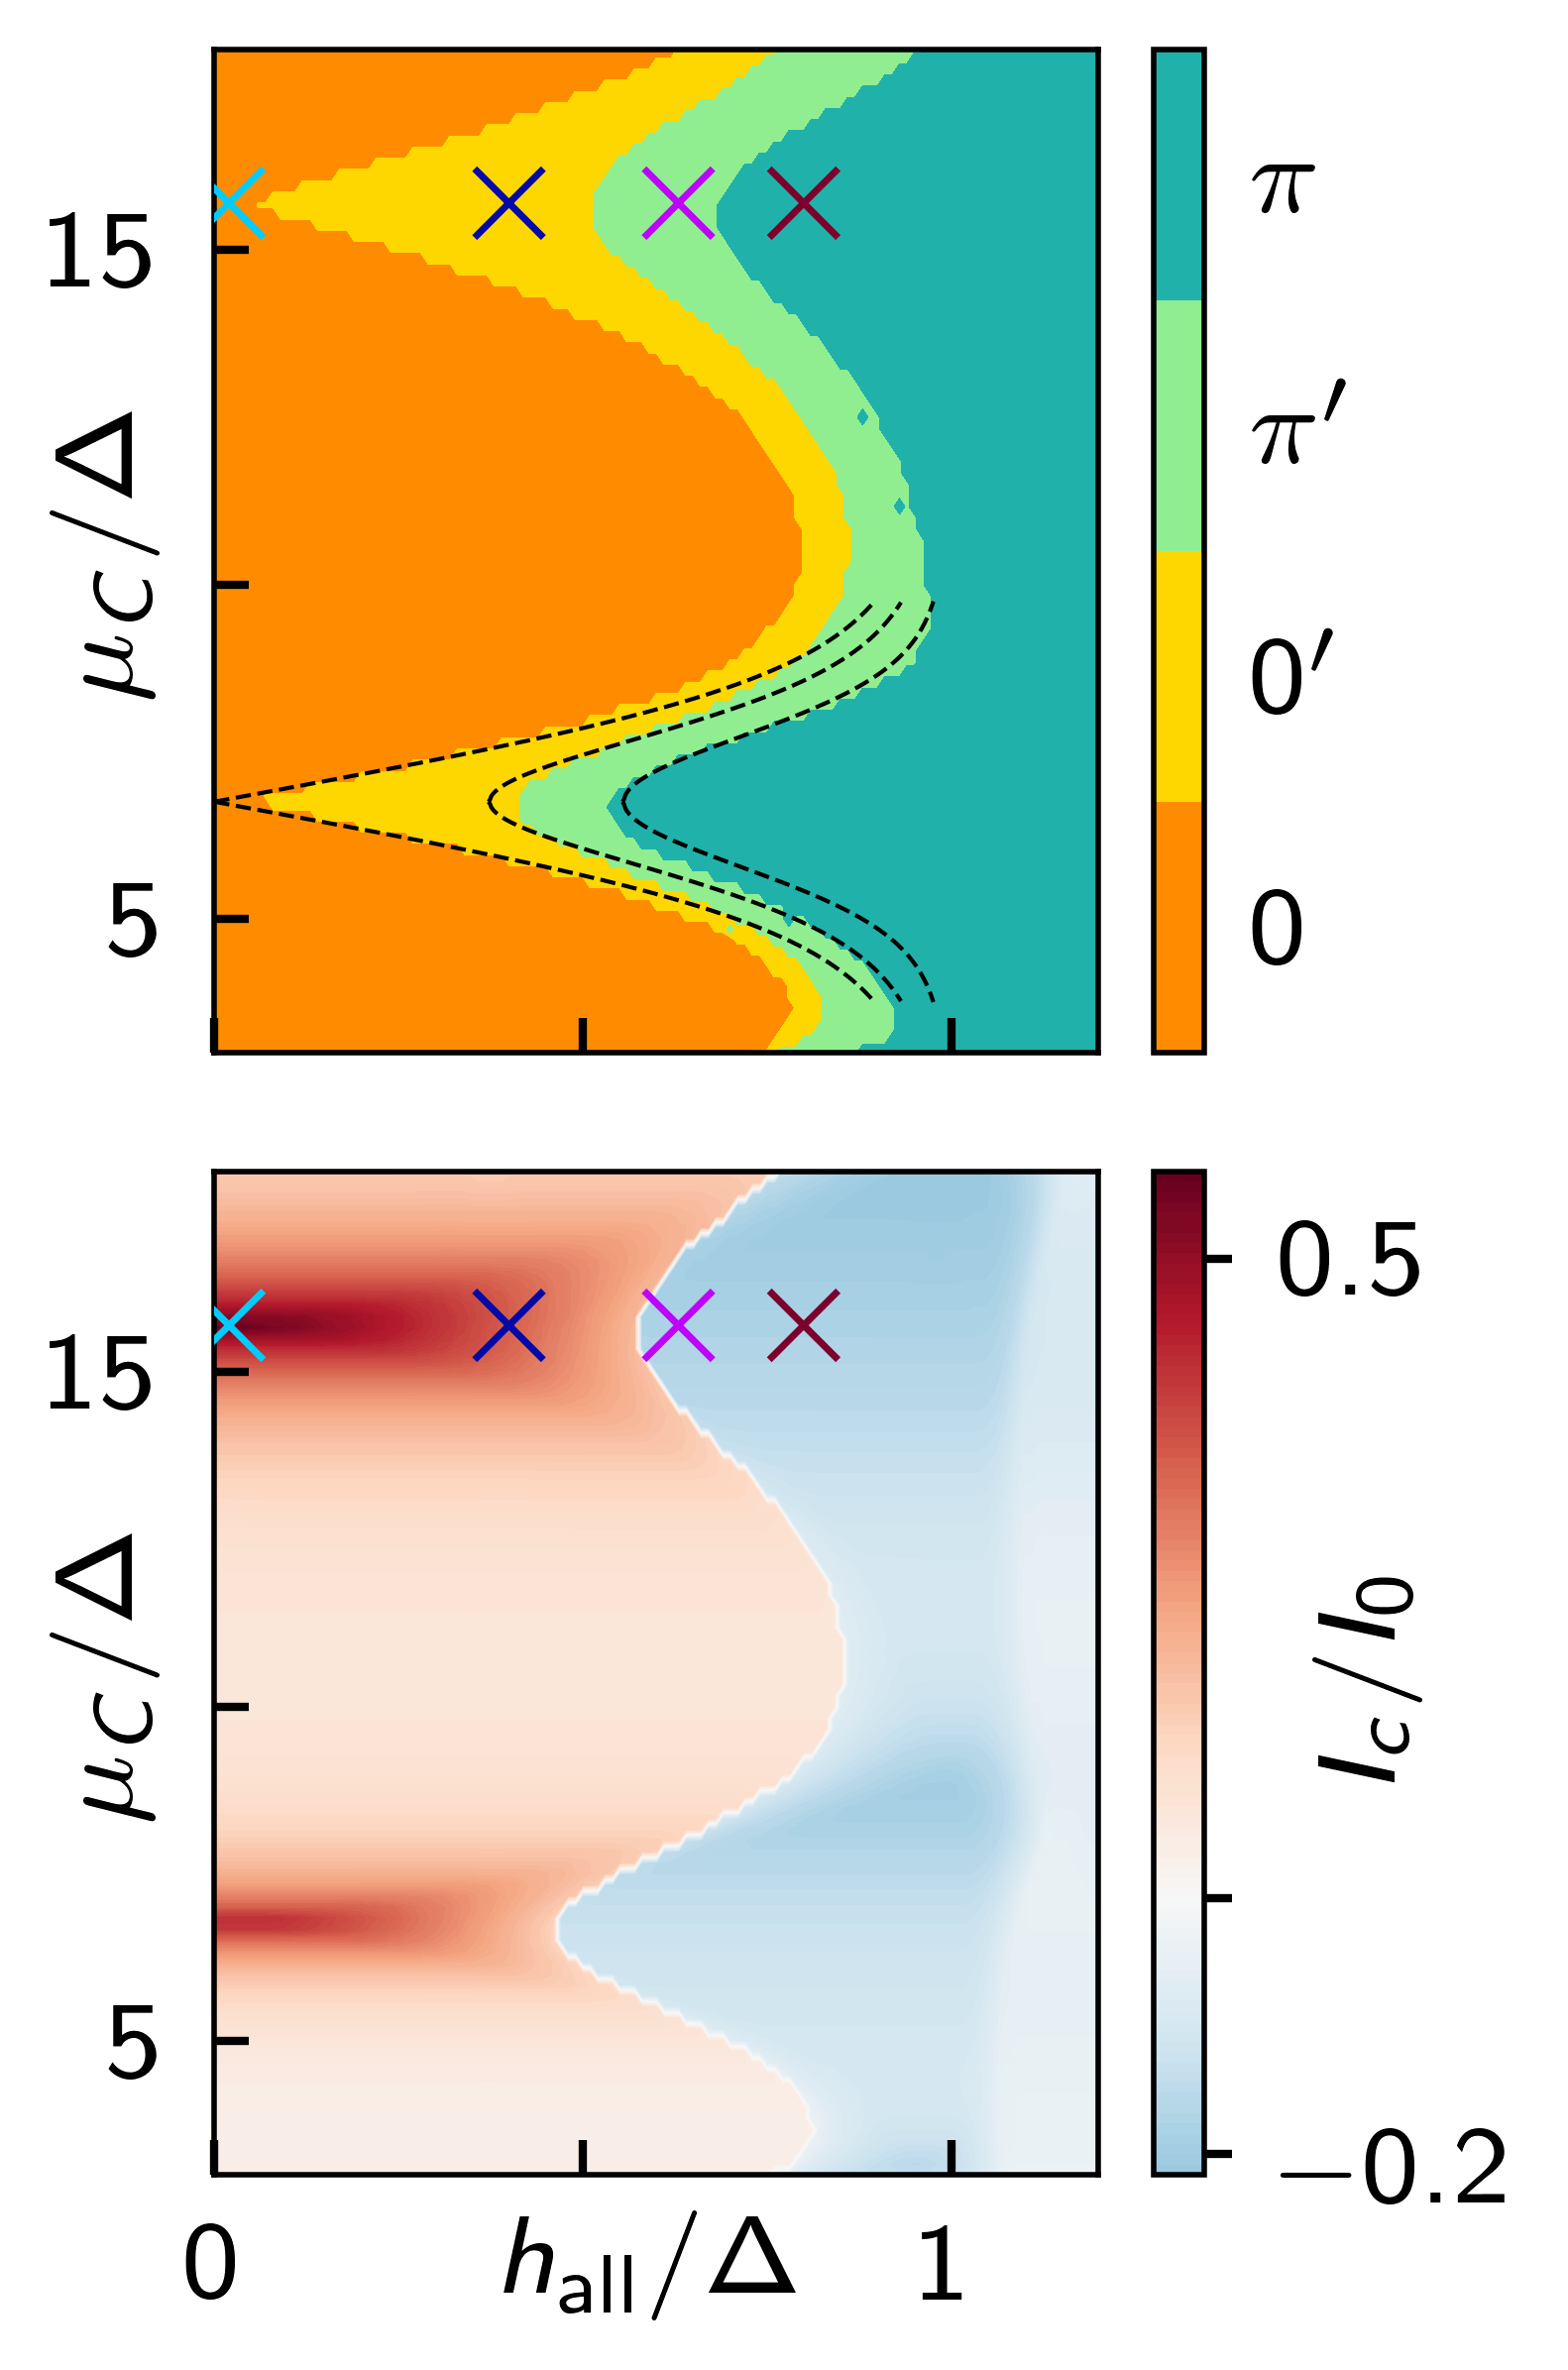

In [15]:
fig, (ax1, ax2) = plt.subplots(
    dpi=1000, figsize=(3.375 * 0.5, 3.375 * 0.75), ncols=1, nrows=2
)

levels = np.linspace(0, 3.2, 5)

im = ax1.contourf(a / a_scale, b / b_scale, pd, levels=levels, cmap=pd_cmap, zorder=-30)

ax1.set_xlim(a_ax.min() / a_scale, a_ax.max() / a_scale)
ax1.set_ylim(b_ax.min() / b_scale, b_ax.max() / b_scale)

# ax1.set_xlabel(a_label)
ax1.set_xticklabels([])
ax1.set_ylabel(b_label, labelpad=-8)


def deps(gamma,Delta_0, h_c, h_l, phi):
    return gamma * np.sqrt((h_c/gamma + 2 * h_l/np.sqrt(Delta_0**2-h_l**2))**2 - 4 * Delta_0**2/(Delta_0**2-h_l**2)*(1-np.sin(phi/2)**2))


h = np.linspace(0, 1, 501) * Delta_0

#lower
gamma = 0.13
eps_0 = 6.75

#upper
#gamma = 0.20
#eps_0 = 15.7

eps_1 = deps(gamma, Delta_0, h, h, 0)
eps_2 = deps(gamma, Delta_0, h, h, np.pi/2)
eps_3 = deps(gamma, Delta_0, h, h, np.pi)

eps_1[np.nanargmin(eps_1)-1] = 0
eps_2[np.nanargmin(eps_2)-1] = 0
eps_3[np.nanargmin(eps_3)-1] = 0

eps_1[abs(eps_1)>3*Delta_0] = np.nan
eps_2[abs(eps_2)>3*Delta_0] = np.nan
eps_3[abs(eps_3)>3*Delta_0] = np.nan

ax1.plot(h/a_scale, eps_0+eps_1/b_scale, '--k', linewidth=0.3)
ax1.plot(h/a_scale, eps_0-eps_1/b_scale, '--k', linewidth=0.3)

ax1.plot(h/a_scale, eps_0+eps_2/b_scale, '--k', linewidth=0.3)
ax1.plot(h/a_scale, eps_0-eps_2/b_scale, '--k', linewidth=0.3)

ax1.plot(h/a_scale, eps_0+eps_3/b_scale, '--k', linewidth=0.3)
ax1.plot(h/a_scale, eps_0-eps_3/b_scale, '--k', linewidth=0.3)


# eps = deps(gamma, Delta_0, h, h, 0)
# eps[0] = 0
# ax2.plot(h_c/a_scale, eps_0+eps/b_scale, '--k')
# ax2.plot(h_c/a_scale, eps_0-eps/b_scale, '--k')

# eps = deps(gamma, Delta_0, h, h, np.pi/2)
# eps[0] = 0

# ax2.plot(h_c/a_scale, eps_0+eps/b_scale, '--k')
# ax2.plot(h_c/a_scale, eps_0-eps/b_scale, '--k')
# eps = deps(gamma, Delta_0, h, h, np.pi)

# eps[0] = 0
# ax2.plot(h_c/a_scale, eps_0+eps/b_scale, '--k')
# ax2.plot(h_c/a_scale, eps_0-eps/b_scale, '--k')

# ax1.vlines(
#     [-1, +1],
#     b_ax.min() / b_scale,
#     b_ax.max() / b_scale,
#     color="k",
#     linestyles=":",
#     linewidths=0.5,
# )

# ax1.vlines(
#     [-1 / np.sqrt(2), +1 / np.sqrt(2)],
#     b_ax.min() / b_scale,
#     b_ax.max() / b_scale,
#     color="k",
#     linestyles="--",
#     linewidths=0.5,
# )

cbar = fig.colorbar(im, ax=ax1)
cbar.set_ticks([1 / 8 * 3.2, 3 / 8 * 3.2, 5 / 8 * 3.2, 7 / 8 * 3.2])
cbar.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
cbar.ax.tick_params(length=0)

ax1.set_rasterization_zorder(-10)

im = ax2.contourf(
    a / a_scale,
    b / b_scale,
    I_c / I_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(),
    cmap="RdBu_r",
    zorder=-30,
)
cbar = fig.colorbar(im, ax=ax2)
ax2.set_xlabel(a_label, labelpad=-8)
ax2.set_ylabel(b_label, labelpad=-8)


# ax2.vlines(
#     [-1, +1],
#     b_ax.min() / b_scale,
#     b_ax.max() / b_scale,
#     color="k",
#     linestyles=":",
#     linewidths=0.5,
# )

# ax2.vlines(
#     [-1 / np.sqrt(2), +1 / np.sqrt(2)],
#     b_ax.min() / b_scale,
#     b_ax.max() / b_scale,
#     color="k",
#     linestyles="--",
#     linewidths=0.5,
# )

cbar.set_ticks([-0.2, 0, 0.5], labels=[r"$-0.2$", "", r"$0.5$"])
cbar.ax.tick_params(length=2, direction="out")
cbar.set_label(r"$I_c / I_0 $", labelpad=-15)

ax2.set_xlim(a_ax.min() / a_scale, a_ax.max() / a_scale)
ax2.set_ylim(b_ax.min() / b_scale, b_ax.max() / b_scale)

ax2.set_rasterization_zorder(-10)

ax1.scatter(coords[:, 0], coords[:, 1], c=line_colors, zorder=10, marker="x")
ax2.scatter(coords[:, 0], coords[:, 1], c=line_colors, zorder=10, marker="x")

ax1.set_ylim(3, 18)
ax2.set_ylim(3, 18)

ax1.set_xticks([0, 0.5, 1], labels=[])
ax2.set_xticks([0, 0.5, 1], labels=[r"$0$", r"", r"$1$"])

ax1.set_yticks([5, 10, 15], labels=[r"$5$", r"", r"$15$"])
ax2.set_yticks([5, 10, 15], labels=[r"$5$", r"", r"$15$"])


# ax1.scatter([0.2, 0.2, 0.2], np.array([1, 4, 9])*1.7)

fig.tight_layout()
fig.savefig("Fig1a.svg")